In [1]:
import sys


import blosc
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import ewma
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline
sys.path.append('..')
import utils
from network import FourHeadedInception
from batch_generator import TwoMnistBatch
from dataset import Dataset, B, V, Pipeline
from dataset.opensets import MNIST


In [2]:
dset = MNIST(batch_class=TwoMnistBatch)

Extracting ExtractingExtracting/tmp/t10k-images-idx3-ubyte.gz 
/tmp/train-images-idx3-ubyte.gzExtracting 
/tmp/t10k-labels-idx1-ubyte.gz 
/tmp/train-labels-idx1-ubyte.gz


In [3]:
ppl = (Pipeline()
       .resize(shape=(128, 128))
       .normalize_images()
       .gluing_of_images()
       .colorize_images(colors=[[0., 0., 1.], [0., 1., 0.]]))

color of first number:  0 
color of second number:  1 
first number is  1 
second number is  1


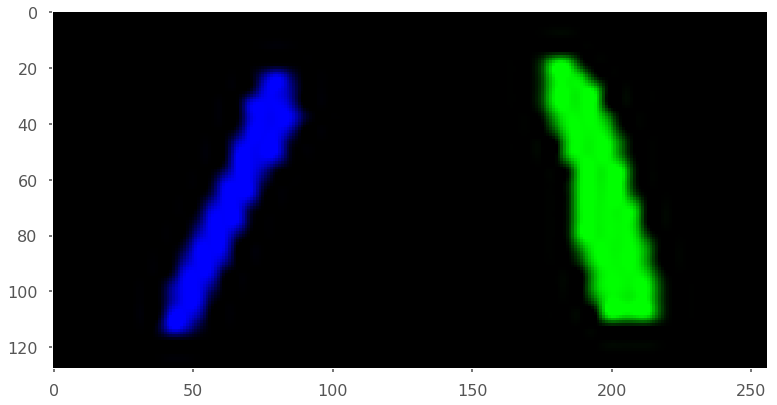

In [4]:
a = (ppl<<dset.train).next_batch(100)
plt.grid()
plt.imshow(a.images[0].reshape(128, -1, 3))
print('color of first number: ', a.first_color[0], '\ncolor of second number: ', a.second_color[0], \
      '\nfirst number is ', a.first_number[0],'\nsecond number is ', a.second_number[0])

In [5]:
inputs_config = {'images': {'shape':(128, 256, 3)},
                 'labels':{'shape':(2)},
                 'fir_col': {'classes':(2), 'transform': 'ohe', 'name':'first_color'},
                 'sec_col': {'classes':(2), 'transform': 'ohe', 'name':'second_color'},
                 'first': {'classes':(10), 'transform': 'ohe', 'name':'first_number'},
                 'second': {'classes':(10), 'transform': 'ohe', 'name':'second_number'}}

config = {'inputs':inputs_config,
          'optimizer': 'Adam',
          'loss': None,
          'input_block/inputs': 'images',
          'head/color_importance': 1.}

four_headed_dict = {'images': B('images'),
                    'labels': B('labels'),
                    'fir_col': B('first_color'),
                    'sec_col': B('second_color'),
                    'first': B('first_number'),
                    'second': B('second_number')}

In [6]:
def create_ppl(config, tp = dset.train):
    four_headed_ppl = ((ppl<<tp)
                        .init_variable('loss_c1', init_on_each_run=list)
                        .init_variable('loss_c2', init_on_each_run=list)
                        .init_variable('loss_n1', init_on_each_run=list)
                        .init_variable('loss_n2', init_on_each_run=list)
                        .init_model('dynamic',
                                    FourHeadedInception,
                                    'fourinception',
                                    config=config)
                       .train_model('fourinception',
                                    fetches=['FourHeadedInception/loss_c1:0',
                                             'FourHeadedInception/loss_c2:0',
                                             'FourHeadedInception/loss_n1:0',
                                             'FourHeadedInception/loss_n2:0'],
                                    feed_dict=four_headed_dict,
                                    save_to=[V('loss_c1'),
                                             V('loss_c2'),
                                             V('loss_n1'),
                                             V('loss_n2')], 
                                    mode='a'))
    return four_headed_ppl

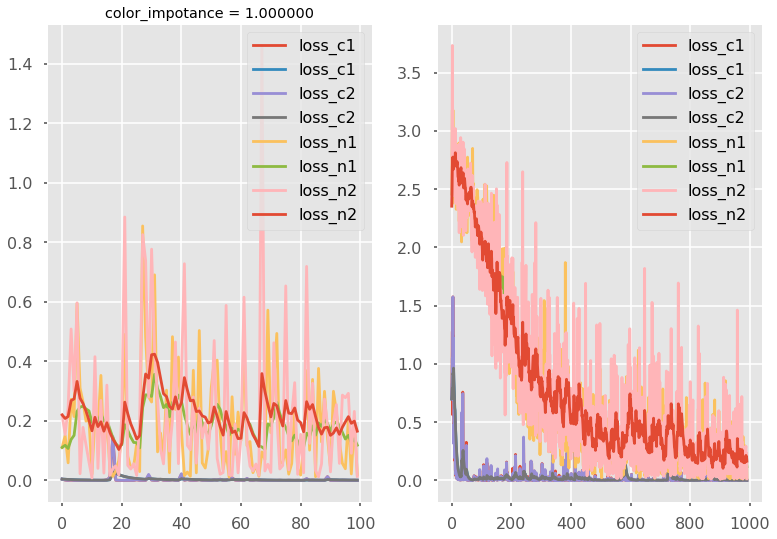

In [7]:
names = ['loss_c1', 'loss_c2', 'loss_n1', 'loss_n2']
global_loss = []
importance = [1]
for imp in tqn(importance):
    config['head/color_importance'] = imp
    new_ppl = create_ppl(config)
    for i in tqn(range(1000)):
        new_ppl.next_batch(20, n_epochs=None, shuffle=True)
        new_test_ppl.next_batch(20, n_epochs=None, shuffle=True)
        if i%10==0:
            clear_output(True)
            losses = [new_ppl.get_variable(name) for name in names]
            utils.four_losses_draw(losses, names, 'color_impotance = %f'%imp)
    global_loss.append(losses)

/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  
/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


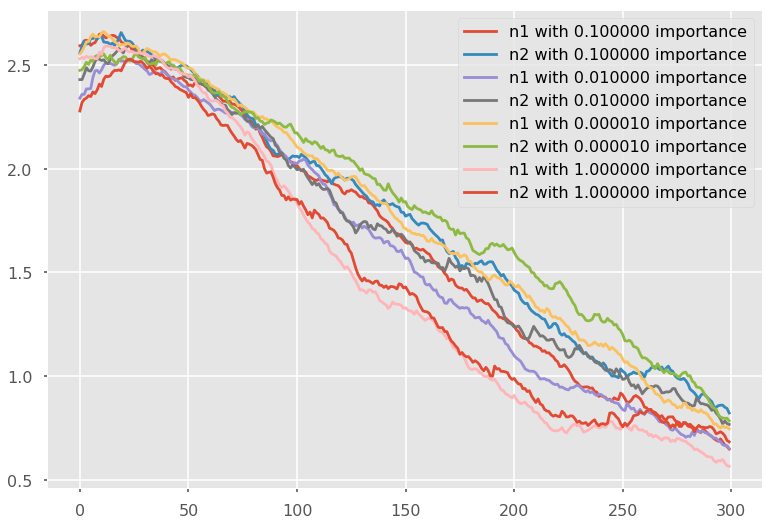

In [28]:
for i in range(4):
    plt.plot(ewma(np.array(global_loss[i][-2]), span=50, adjust=False), label='n1 with %f importance'%importance[i])
    plt.plot(ewma(np.array(global_loss[i][-1]), span=50, adjust=False), label='n2 with %f importance'%importance[i])
    plt.legend()

In [30]:
four_headed_test = ((ppl<<dset.test)
                    .init_variable('first_color', init_on_each_run=list)
                    .init_variable('second_color', init_on_each_run=list)
                    .init_variable('first_num', init_on_each_run=list)
                    .init_variable('second_num', init_on_each_run=list)
                    .init_variable('loss', init_on_each_run=list)
                    .import_model('fourinception', new_ppl)
                    .predict_model('fourinception', 
                                   fetches=['FourHeadedInception/first_color:0', 
                                            'FourHeadedInception/second_color:0',
                                            'FourHeadedInception/first_number:0',
                                            'FourHeadedInception/second_number:0',
                                            'loss'],
                         feed_dict=four_headed_dict,
                         save_to=[V('first_color'),
                                  V('second_color'), 
                                  V('first_num'), 
                                  V('second_num'),
                                  V('loss')], mode='a'))

In [31]:
colors_true = []
numbers_true = []

In [288]:
for i in range(10):
    batch = four_headed_test.next_batch(23)
    loss = four_headed_test.get_variable('loss')

    first_color = four_headed_test.get_variable('first_color')
    second_color = four_headed_test.get_variable('second_color')
    first_num = four_headed_test.get_variable('first_num')
    second_num = four_headed_test.get_variable('second_num')

    if len(colors_true) != 0: 
        colors_true = np.hstack((colors_true, np.hstack((batch.first_color, batch.second_color))))
        numbers_true = np.hstack((numbers_true, np.hstack((batch.first_number, batch.second_number))))
    else:
        colors_true = np.hstack((batch.first_color, batch.second_color))
        numbers_true = np.hstack((batch.first_number, batch.second_number))

    colors_pred = np.hstack((first_color, second_color)).reshape(-1, 2)
    numbers_pred = np.hstack((first_num, second_num)).reshape(-1, 10)

сделать true-positive and true-negative. На что сетка переобучилась и тд.

Accuracy on colors: 0.967 
Accuracy on numbers: 1.000
No errors in color


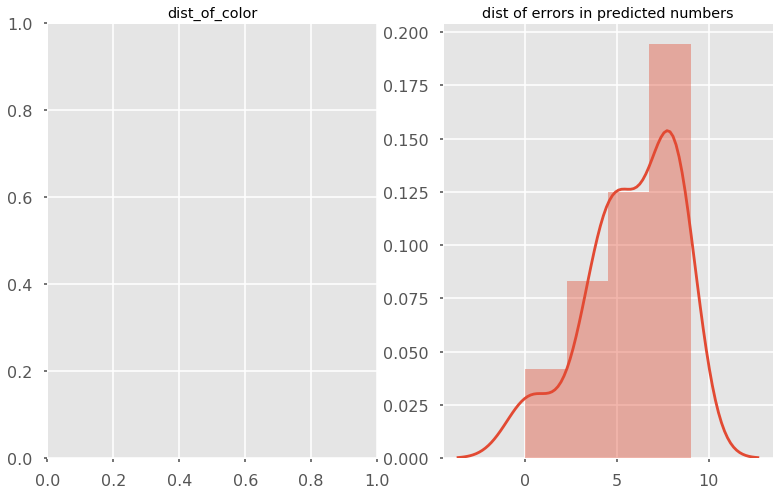

In [335]:
wrong_num, acc_num, wrong_col, acc_col = np.array(list(utils.class_accuracy([numbers_pred,colors_pred], \
                                                                            [numbers_true,colors_true], \
                                                                            [10, 2]))).reshape(-1)
print('Accuracy on colors: %.3f'%acc_num, '\nAccuracy on numbers: %.3f'%acc_col)

_, subplot = plt.subplots(1, 2, figsize=(13, 8))
subplot[0].set_title('dist_of_color')
if len(dist_color) == 0:
    print('No errors in color')
else:
    sns.distplot(wrong_col, ax=subplot[0])
subplot[1].set_title('dist of errors in predicted numbers')
sns.distplot(dist_num, ax=subplot[1])